In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy import stats
from scipy.optimize import minimize 
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.svm import SVC                              
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt  
import seaborn as sns
print("Success import")

Success import


In [17]:
start_date = "2019-01-01"
end_date = None
gold_data = yf.download("GC=F", start_date, end_date , progress= False)
goldprice = gold_data['Close']
print(f" Gold data: {len(goldprice)} days")
silver_data = yf.download('SI=F', start=start_date, end=end_date, progress=False)
silverprice = silver_data['Close']  # Get the closing price
print(f" Silver data: {len(silverprice)} days")

data = pd.concat([goldprice, silverprice], axis=1)
data.columns = ['Gold', 'Silver']

data = data.dropna()


print(f"\nData shape: {data.shape}")
print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
print(f"\nFirst few rows:")
print(data.head())


 Gold data: 1794 days
 Silver data: 1794 days

Data shape: (1794, 2)
Date range: 2019-01-02 to 2026-02-18

First few rows:
                   Gold  Silver
Date                           
2019-01-02  1281.000000  15.542
2019-01-03  1291.800049  15.706
2019-01-04  1282.699951  15.695
2019-01-07  1286.800049  15.669
2019-01-08  1283.199951  15.626


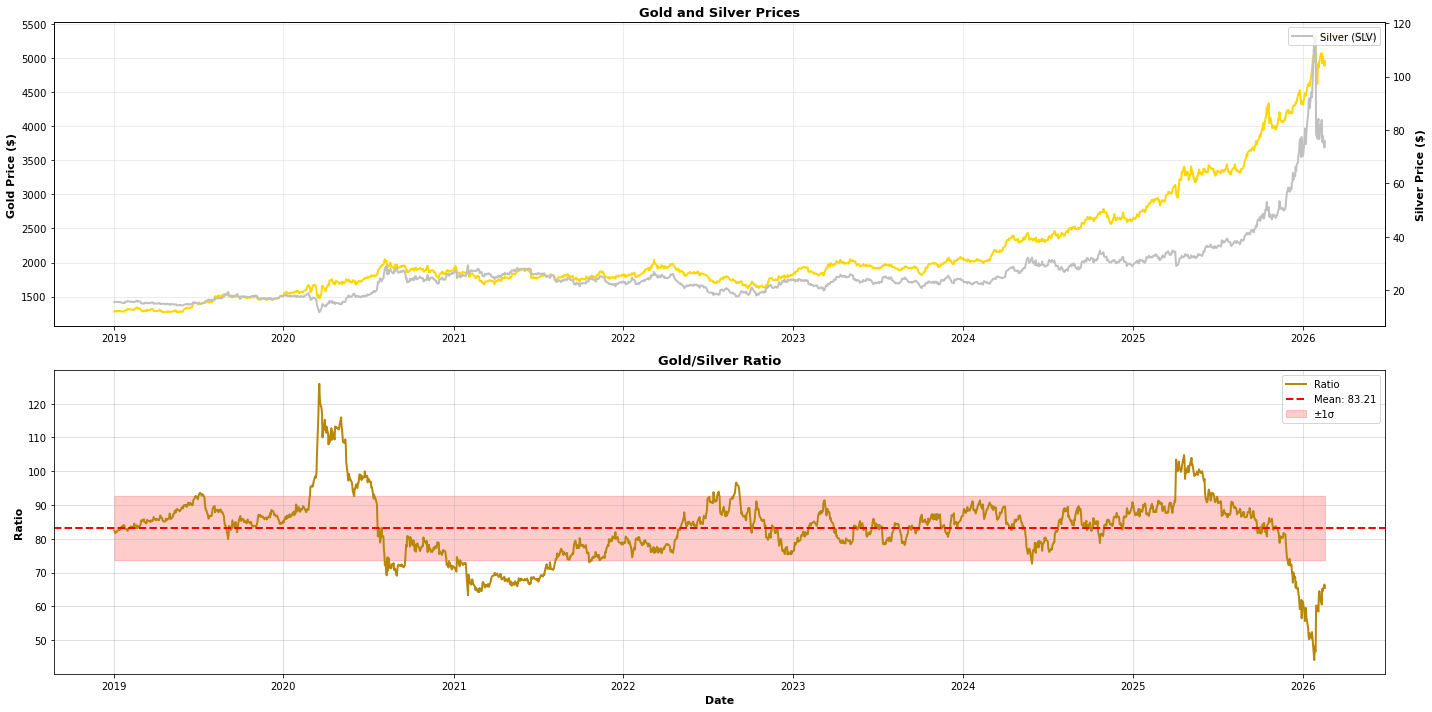

In [18]:
fig, (f1,f2) = plt.subplots(2 , 1 , figsize=(20,10))

x=data.index.to_numpy()
gold=data["Gold"].to_numpy()
slv= data["Silver"].to_numpy()

f1.plot(x,gold,label = "Gold", linewidth=2, color='gold')
f1.set_ylabel('Gold Price ($)', fontsize=11, fontweight='bold')
f1.set_title('Gold and Silver Prices', fontsize=13, fontweight='bold')
f1.legend()
f1.grid(True, alpha=0.3)

f1_twin = f1.twinx()
f1_twin.plot(x, slv, label='Silver (SLV)', linewidth=2, color='silver')
f1_twin.set_ylabel('Silver Price ($)', fontsize=11, fontweight='bold')
f1_twin.legend(loc='upper right')

ratio = gold/slv
mean=ratio.mean()
std= ratio.std()

f2.plot(x, ratio, linewidth=2, color='darkgoldenrod', label='Ratio')
f2.axhline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
f2.fill_between(x, mean - std, mean + std, alpha=0.2, color='red', label='±1σ')

f2.set_ylabel('Ratio', fontsize=11, fontweight='bold')
f2.set_xlabel('Date', fontsize=11, fontweight='bold')
f2.set_title('Gold/Silver Ratio', fontsize=13, fontweight='bold')
f2.legend()
f2.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

In [30]:
from statsmodels.tsa.stattools import coint, adfuller
from scipy import stats as sts

gold_norm = (data['Gold'] - data['Gold'].mean()) / data['Gold'].std()
silver_norm = (data['Silver'] - data['Silver'].mean()) / data['Silver'].std()

print("=" * 60)
print("COINTEGRATION AND STATIONARITY TESTS")
print("=" * 60)

print("\n 1.  Gold ADF Test")
print('-'*60)
result_gold = adfuller(gold_norm , autolag = 'AIC')
print(f" Test Statistics: {result_gold[0]: .6f}")
print(f" p_value: {result_gold[1]: .6f}")

if result_gold[1] < 0.05:
    print(f"  Stationary")
else:
    print(f"  Non-stationary (expected - prices have trends)")

print("\n 2.  Silver ADF Test")
print('-'*60)
result_slv = adfuller(silver_norm , autolag = 'AIC')
print(f" Test Statistics: {result_slv[0]: .6f}")
print(f" p_value: {result_slv[1]: .6f}")

if result_slv[1] < 0.05:
    print(f"  Stationary")
else:
    print(f"  Non-stationary (expected - prices have trends)")

print("\n 3.  Regression Relationship")
print('-'*60)
slope, intercept, r_value, p_val, std_err = sts.linregress(gold_norm, silver_norm)
print(f" Silver = {intercept:.4f} + {slope:.4f} × Gold")
print(f' R² = {r_value**2: .4f}')
print("Long term equillibrium relationship")

spread = silver_norm - intercept - slope * gold_norm

print("\n 4.  ADF on Spread")
print('-'*60)
resultspread = adfuller(spread, autolag ='AIC')
print(f" Test Statistics: {resultspread[0]: .6f}")
print(f" p_value: {resultspread[1]: .6f}")
if resultspread[1] < 0.05:
    print(f"  Spread IS STATIONARY")
    print(f"  Mean reversion will work!")
else:
    print(f"  Spread is NOT stationary")
    print(f"  Mean reversion may not work")
    
print("\n 5.  Cointegration Test on Gold and Silver")
print('-'*60)
score , p_value, _ = coint(gold_norm, silver_norm)
print(f" Test Statistics: {score: .6f}")
print(f" p_value: {p_value: .6f}")
if p_value < 0.10:
    print(f"  COINTEGRATED! (p < 0.10)")
    print(f"  Gold and Silver have a long-term relationship")
else:
    print(f"  NOT COINTEGRATED (p >= 0.10)")
    print(f"  Strategy may not work")
    
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)

if p_value<0.10 and resultspread[1]< 0.05:
    print("CONDITIONS MET FOR MEAN REVERSION STRATEGY")
    print("  Gold and Silver are cointegrated")
    print("  The spread is stationary")
    print("  Strategy is theoretically valid!")
elif p_value < 0.10:
    print(" PARTIAL CONDITIONS MET")
    print("   Gold and Silver are cointegrated")
    print("   But spread is NOT stationary")
    print("   Strategy may not work well")
elif resultspread[1] < 0.05:
    print(" PARTIAL CONDITIONS MET")
    print("   Gold and Silver are NOT cointegrated")
    print("   But spread is stationary")
    print("   Strategy may not work well")
else:
    print(" CONDITIONS NOT MET")
    print("   Gold and Silver are NOT cointegrated")
    print("   Mean reversion strategy is invalid")
    print("   Try different assets or time period")

print("=" * 60)

COINTEGRATION AND STATIONARITY TESTS

 1.  Gold ADF Test
------------------------------------------------------------
 Test Statistics:  5.535837
 p_value:  1.000000
  Non-stationary (expected - prices have trends)

 2.  Silver ADF Test
------------------------------------------------------------
 Test Statistics:  1.729641
 p_value:  0.998199
  Non-stationary (expected - prices have trends)

 3.  Regression Relationship
------------------------------------------------------------
 Silver = 0.0000 + 0.9202 × Gold
 R² =  0.8467
Long term equillibrium relationship

 4.  ADF on Spread
------------------------------------------------------------
 Test Statistics: -3.848048
 p_value:  0.002452
  Spread IS STATIONARY
  Mean reversion will work!

 5.  Cointegration Test on Gold and Silver
------------------------------------------------------------
 Test Statistics: -3.261242
 p_value:  0.060269
  COINTEGRATED! (p < 0.10)
  Gold and Silver have a long-term relationship

SUMMARY
CONDITIONS MET

In [20]:
class KalmanFilter:
    def __init__(self, goldp, silverp, process_var = 1e-5, measurement_var = 0.01):
        
        self.gold = np.array(goldp, dtype = float)
        self.silver = np.array(silverp, dtype = float)
        self.Q = process_var
        self.R = measurement_var
    
    def filter(self):
        beta, alpha, _, _,_ = sts.linregress(self.gold[:100], self.silver[:100])
        p = 0.1
        betas=[]
        alphas =[]
        for t in range(0,len(self.gold)):
            x_t = self.gold[t]
            y_t = self.silver[t]
            
            y_pred = alpha + beta*x_t
            innovation = y_t - y_pred
            
            s = p + self.R
            
            k = p/s
            beta = beta + k* innovation*x_t/ (1+x_t**2)
            if abs(beta) > 100:
                beta = np.sign(beta) * 100

            p = (1-k)*p + self.Q
            alpha = alpha + 0.001 * innovation
            
            betanormal = beta*data["Silver"].std()/data["Gold"].std()
            alphanorm = data["Silver"].mean() + data["Silver"].std()*alpha -betanormal*data["Gold"].mean()
            betas.append(betanormal)
            alphas.append(alphanorm)
        return np.array(betas), np.array(alphas)

print("Running Kalman Filter...\n")
kf = KalmanFilter(gold_norm, silver_norm)
betas, alphas = kf.filter()

print(f"✓ Kalman filter complete!")
print(f"\nDynamic Hedge Ratio β(t) Statistics:")
print(f"  Mean: {betas.mean():.6f}")
print(f"  Std:  {betas.std():.6f}")
print(f"  Min:  {betas.min():.6f}")
print(f"  Max:  {betas.max():.6f}")
print(f"\n  (β changes over time as market conditions change)")


Running Kalman Filter...

✓ Kalman filter complete!

Dynamic Hedge Ratio β(t) Statistics:
  Mean: 0.022419
  Std:  0.007200
  Min:  0.005046
  Max:  0.032353

  (β changes over time as market conditions change)


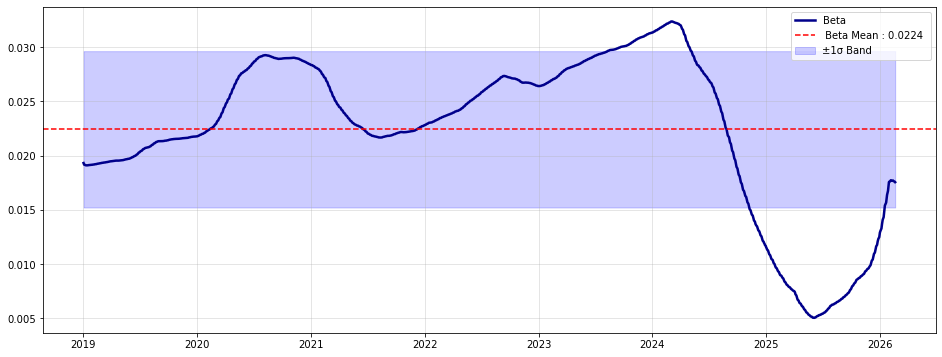

In [21]:
fig, a = plt.subplots(figsize=(16, 6))

a.plot(x , betas, color = 'darkblue', linewidth = '2.5', label = "Beta")
a.axhline(betas.mean(), color = 'red' , linestyle = '--', label = f" Beta Mean :{betas.mean(): .4f} ")
a.fill_between(x, betas.mean()-betas.std(), betas.mean() + betas.std(),color = 'blue', alpha = 0.2, label = '±1σ Band')
a.legend()
a.grid(True, alpha = 0.4)
plt.show()

Spread Statistics:
  Mean: -1.114631
  Std:  4.076694
  Min:  -10.060165
  Max:  36.101625


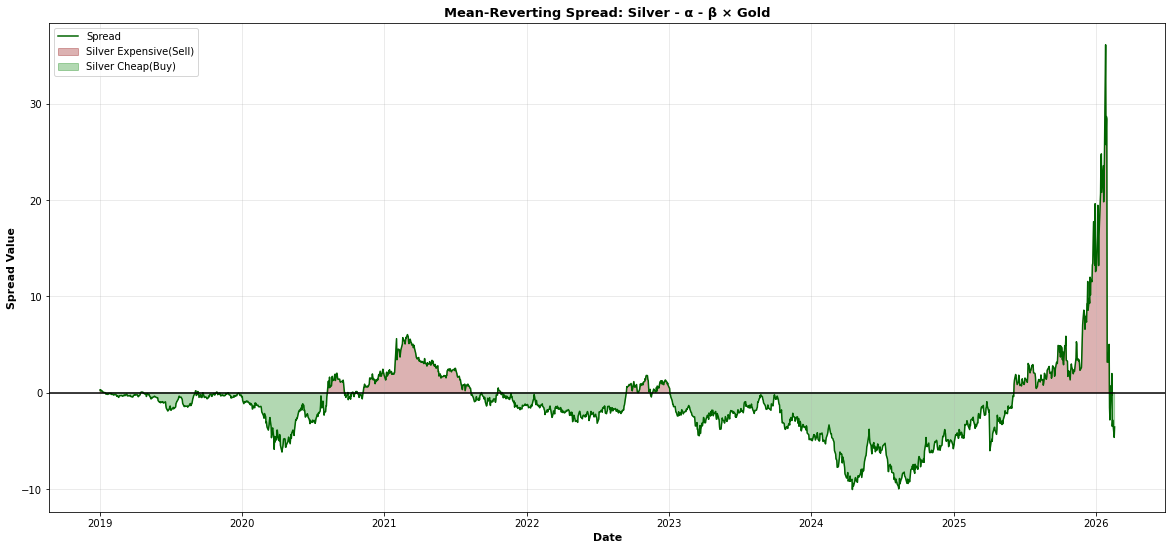

In [22]:
spread = data["Silver"] - alphas - betas*data["Gold"]
spread = pd.Series(spread, index= data.index)

print(f"Spread Statistics:")
print(f"  Mean: {spread.mean():.6f}")
print(f"  Std:  {spread.std():.6f}")
print(f"  Min:  {spread.min():.6f}")
print(f"  Max:  {spread.max():.6f}")

fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(x,spread.to_numpy(),color = 'darkgreen', linewidth = '1.5', label = "Spread")
ax.axhline(0, color = 'black' )
ax.fill_between(x, spread, 0 , where =(spread>=0), alpha = 0.3, color = 'darkred', label="Silver Expensive(Sell)")
ax.fill_between(x, spread, 0 , where =(spread<0), alpha = 0.3, color = 'green', label="Silver Cheap(Buy)")
ax.legend()
ax.set_ylabel('Spread Value', fontsize=11, fontweight='bold')
ax.set_xlabel('Date', fontsize=11, fontweight='bold')
ax.set_title('Mean-Reverting Spread: Silver - α - β × Gold', fontsize=13, fontweight='bold')
ax.grid(True, alpha = 0.3)
plt.show()



In [23]:
spread_mean = spread.rolling(window = 20).mean()
spread_std = spread.rolling(window = 20).std()
z_score = (spread - spread_mean)/spread_std
print(len(z_score))
print(f"Z-Score Statistics:")
print(f"  Mean: {z_score.mean():.6f} (should be ≈ 0)")
print(f"  Std:  {z_score.std():.6f} (should be ≈ 1)")
print(f"  Min:  {z_score.min():.2f}")
print(f"  Max:  {z_score.max():.2f}")

longsignal = (z_score < -1).sum()
shortsignal = (z_score > 1).sum()

print(f"\nSignal Occurrences:")
print(f"  Long signals (Z < -1σ):  {longsignal} days")
print(f"  Short signals (Z > +1σ): {shortsignal} days")

1794
Z-Score Statistics:
  Mean: 0.014727 (should be ≈ 0)
  Std:  1.307152 (should be ≈ 1)
  Min:  -3.48
  Max:  3.67

Signal Occurrences:
  Long signals (Z < -1σ):  454 days
  Short signals (Z > +1σ): 473 days


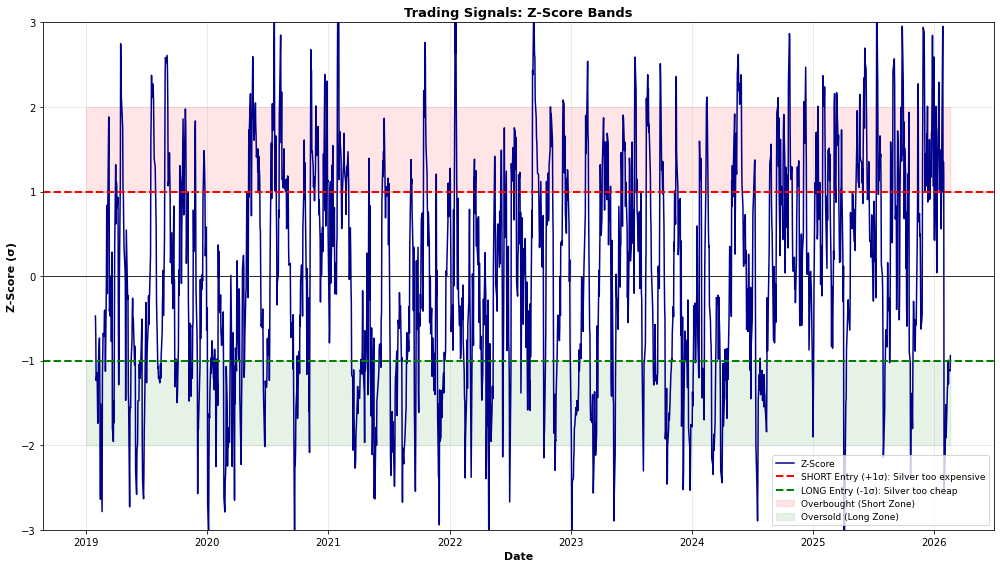

In [24]:
fig, ax = plt.subplots(figsize=(14, 8))

# Plot Z-score
ax.plot(x, z_score.to_numpy(), linewidth=1.5, color='darkblue', label='Z-Score')

# Trading bands
ax.axhline(1.0, color='red', linestyle='--', linewidth=2, label='SHORT Entry (+1σ): Silver too expensive')
ax.axhline(-1.0, color='green', linestyle='--', linewidth=2, label='LONG Entry (-1σ): Silver too cheap')
ax.axhline(0, color='black', linestyle='-', linewidth=0.8)

# Highlight overbought/oversold zones
ax.fill_between(x, 1, 2, alpha=0.1, color='red', label='Overbought (Short Zone)')
ax.fill_between(x, -1, -2, alpha=0.1, color='green', label='Oversold (Long Zone)')

ax.set_ylabel('Z-Score (σ)', fontsize=11, fontweight='bold')
ax.set_xlabel('Date', fontsize=11, fontweight='bold')
ax.set_title('Trading Signals: Z-Score Bands', fontsize=13, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

 No Signal: 1323 days
 Long: 239 days
 Short: 232 days


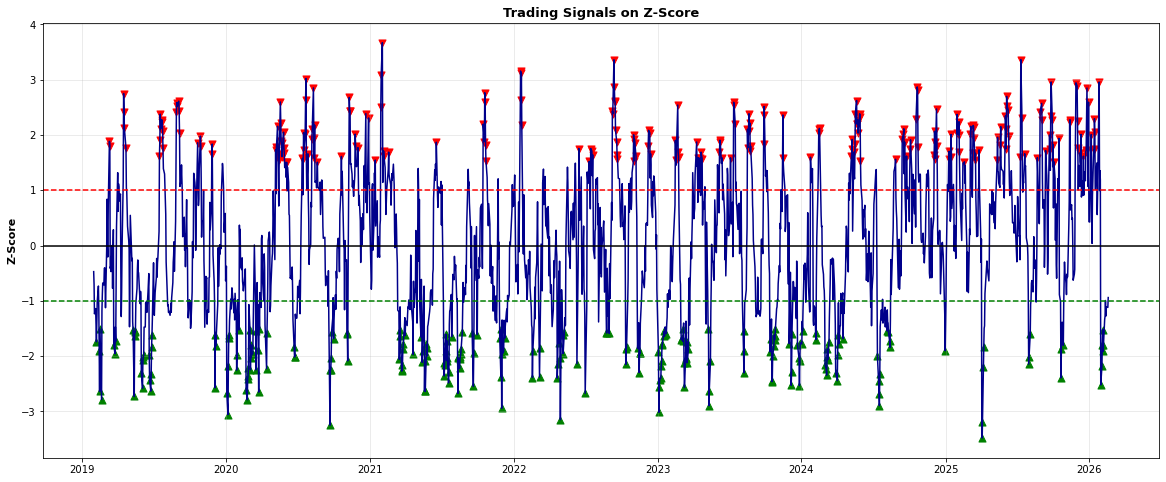

In [25]:
signal = pd.DataFrame(index = z_score.index)
signal['z_score'] = z_score
signal['signal'] = 0

long_mask = z_score < -1.5
signal.loc[long_mask, 'signal'] = 1

short_mask = z_score > 1.5
signal.loc[short_mask, 'signal'] = -1

print(f" No Signal: {(signal['signal'] ==0).sum()} days")
print(f" Long: {(signal['signal'] == -1).sum()} days")
print(f" Short: {(signal['signal'] == 1).sum()} days")

fig, ax1 = plt.subplots(figsize = (20,8))

ax1.plot(x, z_score.values, linewidth = '1.5', color = 'darkblue')
ax1.axhline(1, linestyle = '--', color = 'red')
ax1.axhline(-1, linestyle = '--', color = 'green')
ax1.axhline(0, linestyle = '-', color = 'black')

long_sig = signal[signal['signal'] == 1].index
ax1.scatter(long_sig, z_score[long_sig], color = 'green', marker = '^', s=50)

short_sig = signal[signal['signal'] == -1].index
ax1.scatter(short_sig, z_score[short_sig], color = 'red', marker = 'v', s=50)

ax1.set_ylabel('Z-Score', fontsize=11, fontweight='bold')
ax1.set_title('Trading Signals on Z-Score', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)



In [26]:
from dataclasses import dataclass
@dataclass

class Trade:
    start_date : any
    start_z : float
    start_spread : float
    position: str
    end_z : float = None
    end_spread: float = None
    end_date: any= None 
    pnl : float = 0.0
    profitable : bool = False
    holdingperiod : int = 0
    
    def __str__(self):
        return (f" {self.position.upper():5} | " 
               f"Entry: {self.start_date.date() } @ Spr: {self.start_spread:+.2f} |"
                f"Exit: {(self.end_date.date() if self.end_date else 'OPEN')} @ Spr: {self.end_spread:+.2f} |"
                f"Pnl: {self.pnl:.5f}"
                )
        
    

In [27]:
def backtest(z_score, spread, signal, threshold = 2.0, holdingperiod = 30):
    
    trades = []
    opentrade = []
    
    for t in range(0,len(signal)-1):
        current_date = signal.index[t]
        current_z = z_score.iloc[t]
        current_spread = spread.iloc[t]
        current_signal = signal['signal'].iloc[t]
        
        trades_toclose = []
        
        for i,trade in enumerate(opentrade):
            
            daysheld = (current_date - trade.start_date).days
            exit = False
            
            if abs(current_z) < 0.2:
                exit = True
            elif trade.position == 'long' and current_z<(trade.start_z - 1.5):
                exit = True
            elif trade.position == 'short' and current_z>(trade.start_z + 1.5):
                exit = True               
            elif daysheld> holdingperiod:
                exit = True
            
            if exit:
                trade.end_z = current_z
                trade.end_date = current_date
                trade.end_spread = current_spread
                trade.holdingperiod = daysheld
            
                if trade.position == 'long':
                    trade.pnl = current_spread - trade.start_spread
                elif trade.position == 'short':
                    trade.pnl = trade.start_spread - current_spread
                
            
                trade.profitable = trade.pnl>0
                trades.append(trade)
                trades_toclose.append(i)
            
        for i in reversed(trades_toclose):
            opentrade.pop(i)
        
        if current_signal != 0:
            position = 'long' if current_signal == 1 else 'short'
            newtrade = Trade(start_date = current_date,
                             start_spread= current_spread,
                             start_z= current_z,
                             position= position)
            opentrade.append(newtrade)
    return trades

print("Running backtest...\n")
trades = backtest(z_score, spread, signal, 
                         threshold=2.0, 
                         holdingperiod=30)

print(f"✓ Backtest complete!\n")
print(f"Total Trades: {len(trades)}")
if len(trades) > 0:
    print(f"\nFirst 10 trades:")
    for i, trade in enumerate(trades[:100], 1):
        print(f"  {i:2d}. {trade}")

Running backtest...

✓ Backtest complete!

Total Trades: 464

First 10 trades:
   1.  LONG  | Entry: 2019-02-06 @ Spr: -0.25 |Exit: 2019-03-04 @ Spr: -0.30 |Pnl: -0.04164
   2.  LONG  | Entry: 2019-02-13 @ Spr: -0.28 |Exit: 2019-03-04 @ Spr: -0.30 |Pnl: -0.01358
   3.  LONG  | Entry: 2019-02-14 @ Spr: -0.38 |Exit: 2019-03-04 @ Spr: -0.30 |Pnl: 0.08206
   4.  LONG  | Entry: 2019-02-15 @ Spr: -0.31 |Exit: 2019-03-04 @ Spr: -0.30 |Pnl: 0.01149
   5.  LONG  | Entry: 2019-02-19 @ Spr: -0.50 |Exit: 2019-03-04 @ Spr: -0.30 |Pnl: 0.19970
   6.  SHORT | Entry: 2019-03-11 @ Spr: -0.17 |Exit: 2019-03-18 @ Spr: -0.31 |Pnl: 0.13894
   7.  SHORT | Entry: 2019-03-12 @ Spr: -0.17 |Exit: 2019-03-18 @ Spr: -0.31 |Pnl: 0.13814
   8.  LONG  | Entry: 2019-03-22 @ Spr: -0.41 |Exit: 2019-04-12 @ Spr: -0.33 |Pnl: 0.07656
   9.  LONG  | Entry: 2019-03-25 @ Spr: -0.44 |Exit: 2019-04-12 @ Spr: -0.33 |Pnl: 0.10637
  10.  LONG  | Entry: 2019-03-27 @ Spr: -0.45 |Exit: 2019-04-12 @ Spr: -0.33 |Pnl: 0.12447
  11.  SH

In [28]:
if len(trades) > 0:
    pnls = [t.pnl for t in trades]
    metrics = {
        'total_trades': len(trades),
        'winning_trades': sum(1 for t in trades if t.profitable),
        'losing_trades': sum(1 for t in trades if not t.profitable),
        'win_rate': sum(1 for t in trades if t.profitable) / len(trades),
        'avg_pnl': np.mean(pnls),
        'total_pnl': np.sum(pnls),
        'max_pnl': np.max(pnls),
        'min_pnl': np.min(pnls),
        'std_pnl': np.std(pnls),
    }
    
    # Profit factor
    gains = sum(p for p in pnls if p > 0)
    losses = abs(sum(p for p in pnls if p < 0))
    metrics['profit_factor'] = gains / losses if losses > 0 else 0
    
    print("=" * 70)
    print("PERFORMANCE METRICS")
    print("=" * 70)
    print(f"\nTrade Statistics:")
    print(f"  Total Trades:      {metrics['total_trades']}")
    print(f"  Winning Trades:    {metrics['winning_trades']}")
    print(f"  Losing Trades:     {metrics['losing_trades']}")
    print(f"  Win Rate:          {metrics['win_rate']:.1%}")
    
    print(f"\nPnL Statistics:")
    print(f"  Average PnL:       {metrics['avg_pnl']:+.6f}")
    print(f"  Total PnL:         {metrics['total_pnl']:+.6f}")
    print(f"  Max PnL:           {metrics['max_pnl']:+.6f}")
    print(f"  Min PnL:           {metrics['min_pnl']:+.6f}")
    print(f"  Profit Factor:     {metrics['profit_factor']:.2f}")
    
    print("\n" + "=" * 70)
else:
    print("No trades generated. Try adjusting parameters.")

PERFORMANCE METRICS

Trade Statistics:
  Total Trades:      464
  Winning Trades:    303
  Losing Trades:     161
  Win Rate:          65.3%

PnL Statistics:
  Average PnL:       +0.397958
  Total PnL:         +184.652619
  Max PnL:           +29.427185
  Min PnL:           -8.290499
  Profit Factor:     2.17



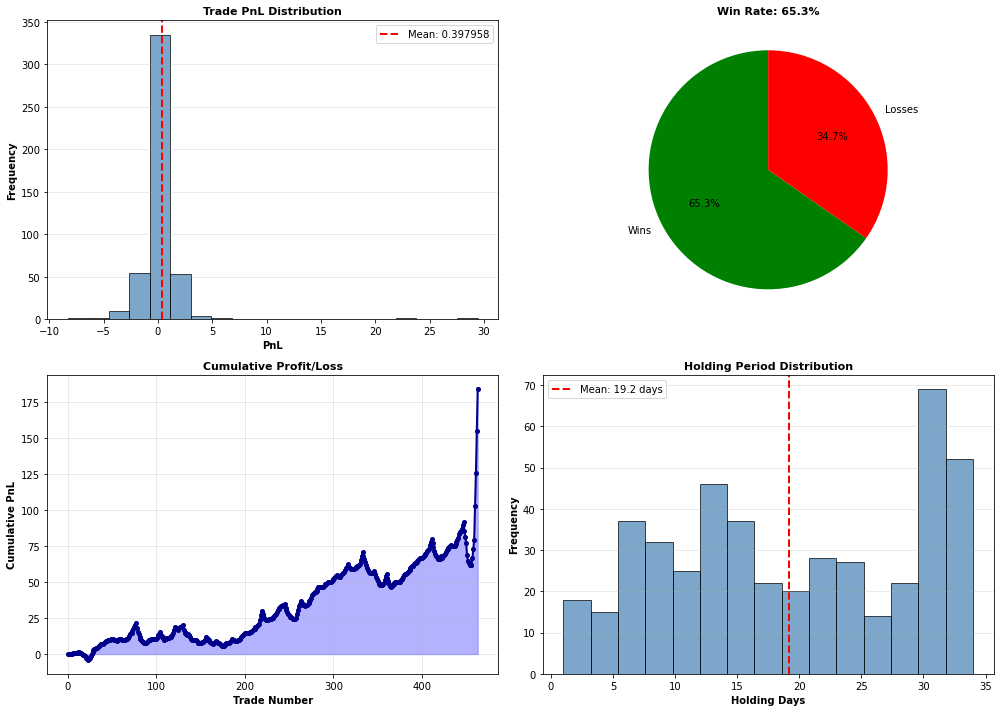

In [29]:
if len(trades) > 0:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    pnls = [t.pnl for t in trades]
    
    # 1. PnL Distribution
    ax1.hist(pnls, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    ax1.axvline(np.mean(pnls), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {np.mean(pnls):.6f}')
    ax1.set_xlabel('PnL', fontsize=10, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=10, fontweight='bold')
    ax1.set_title('Trade PnL Distribution', fontsize=11, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Win vs Loss
    win_count = sum(1 for p in pnls if p > 0)
    loss_count = len(pnls) - win_count
    ax2.pie([win_count, loss_count], labels=['Wins', 'Losses'], 
           autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
    ax2.set_title(f'Win Rate: {win_count/len(pnls):.1%}', fontsize=11, fontweight='bold')
    
    # 3. Cumulative PnL
    cumulative_pnl = np.cumsum(pnls)
    ax3.plot(range(len(cumulative_pnl)), cumulative_pnl, marker='o', 
            color='darkblue', linewidth=2, markersize=4)
    ax3.fill_between(range(len(cumulative_pnl)), cumulative_pnl, 0, alpha=0.3, color='blue')
    ax3.set_xlabel('Trade Number', fontsize=10, fontweight='bold')
    ax3.set_ylabel('Cumulative PnL', fontsize=10, fontweight='bold')
    ax3.set_title('Cumulative Profit/Loss', fontsize=11, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. Holding Days
    holding_days = [t.holdingperiod for t in trades]
    ax4.hist(holding_days, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
    ax4.axvline(np.mean(holding_days), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {np.mean(holding_days):.1f} days')
    ax4.set_xlabel('Holding Days', fontsize=10, fontweight='bold')
    ax4.set_ylabel('Frequency', fontsize=10, fontweight='bold')
    ax4.set_title('Holding Period Distribution', fontsize=11, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()